# Using a Neural Network to Predict Upvotes

In [2]:
# General intuition- http://suruchifialoke.com/2017-05-25-hacker-net-nlp/#linear-regression

import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
import matplotlib.pyplot as plt


"""
Our goal here is to predict upvotes. Lets follow the steps in the link and see what we can come up with
1. Preprocess data
- tokenize the column 
- remove punctuations
- convert all into lower case

2. convert into dataframe and count the frequency
"""

# 1. 

# read file and rename columns
submissions = pd.read_csv("C:/Users/Darshil/Desktop/Dreams/Other/sel_hn_stories.csv")
submissions.columns = ['date', 'upvotes', 'url', 'headlines']

# We'll have to drop rows with blank spaces 
submissions = submissions.dropna()
submissions.head()

C:\Users\Darshil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


,date,upvotes,url,headlines
0,2010-02-17T16:57:59Z,1,blog.jonasbandi.net,Software: Sadly we did adopt from the construc...
1,2014-02-04T02:36:30Z,1,blogs.wsj.com,Google’s Stock Split Means More Control for L...
2,2011-10-26T07:11:29Z,1,threatpost.com,SSL DOS attack tool released exploiting negoti...
3,2011-04-03T15:43:44Z,67,algorithm.com.au,Immutability and Blocks Lambdas and Closures
4,2013-01-13T16:49:20Z,1,winmacsofts.com,Comment optimiser la vitesse de Wordpress?


In [40]:
"""
1.
Now lets preprocess, begin with tokenizing each headline 
a. tokenize each headline
b. remove punctuation
c. make all lowercase
d. remove stopwords for now
e. Then take these words, get all unique and then put into a unqique list (which will become column names)
"""
punctuations_list = [",", ":", ";", ".", "'", '"', "’", "?", "/", "-", "+", "&", "(", ")", "/"]
sw = stopwords.words('english')

pre_unique = []
clean_list = []

for x in submissions['headlines']:
    s = word_tokenize(x)
    clean_list.append(s)
    for word in s:
        if word not in sw and word not in punctuations_list:
            word1 = word.lower()
            pre_unique.append(word1)
                    
# #e.  Now get all unique words using set    
ss = list(set(pre_unique))


"""
2.
Next up, before we make this unique list into columns, we need to first convert the unique list into columns 
and then count frequency of each of those unique words in each headline
a. make dataframe using pandas- remember that we add 0 in the beginning because then we will add to each to get count!
b. Peform the counting 
c. Remove all noise words:
- meaning that any word occuring less than 5 or more than 100

"""
# a. Make dataframe out of columns
counts = pd.DataFrame(0, index = np.arange(submissions.shape[0]), columns = ss)

#b. Now for each list in lame, so technically each row, we go through and if word is in any column then add
for i, x in enumerate(clean_list):
    for word in x:
        if word in ss:
            counts.iloc[i][word] += 1 

# c . first we count then we remove. Note how its done here             
word_counts = counts.sum(axis=0)
counts = counts.loc[:, (word_counts >= 5) & (word_counts <=100)]

In [41]:
counts.head()

,use,big,than,using,user,client,media,my,|,does,...,security,could,do,testing,wireless,still,pay,'ve,book,engine
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Now train Using a Neural Network  - Tensorflow

In [50]:
training_y = submissions['upvotes'].values
training_x = counts.values

X = tf.placeholder("float")
Y = tf.placeholder("float")
# weights for output layer
wL = tf.Variable(tf.random_normal([training_x.shape[1],1]))
bL = tf.Variable(tf.random_normal([1,1]))

# Set up the linear model
prediction = tf.add(tf.matmul(X,wL), bL)

# Now lets set up a cost function- remember that this is a regression problem so we can use the mean squared error
# Also number of samples
n_samples = training_x.shape[0]

# Mean squared error = sum(yhat - y)**2 / m,  cost is as follows:  
cost = tf.reduce_mean(tf.square(prediction-Y))

# Gradient descent
learning_rate = 0.05
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

lfp = []

with tf.Session() as sess:
    sess.run(init)    
    
#     Lets begin training    
    for epoch in range(1000):        
        _, loss = sess.run([optimizer,cost],  feed_dict = {X: training_x, Y: training_y})
        lfp.append(loss)

                                
        if (epoch+1) % 100 == 0:        
            c = sess.run(cost, feed_dict={X: training_x, Y:training_y})
            print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c), "W=", sess.run(wL), "b=", sess.run(bL))
            
    print ("Optimization Finished!")
    training_cost = sess.run(cost, feed_dict={X: training_x, Y: training_y})
    print ("Training cost=", training_cost, "W=", sess.run(wL), "b=", sess.run(bL))
    

    """
    PREDICTION
    - Now we use the trained model to predict on some inputs
    - for now we'll just pick a row from the existing training data to make it work
    """    
    
    row = 18
    px = training_x[row,:]
    py = training_y[row]
    print ("The predicted value is: ", sess.run(prediction, feed_dict = {X: [px], Y: py }))   

Epoch: 0100 cost= 1586.229370117 W= [[1.7783421 ]
 [1.9688472 ]
 [2.1768801 ]
 [2.3110452 ]
 [3.7729456 ]
 [3.1123283 ]
 [4.5995207 ]
 [0.836903  ]
 [1.1951276 ]
 [3.6279666 ]
 [3.806119  ]
 [3.2862735 ]
 [1.4100245 ]
 [3.5575328 ]
 [2.189418  ]
 [4.2486143 ]
 [4.329036  ]
 [2.8351326 ]
 [2.9655497 ]
 [4.004705  ]
 [1.9053652 ]
 [1.9733173 ]
 [2.8537865 ]
 [1.9566779 ]
 [3.9148803 ]
 [2.5509    ]
 [1.854451  ]
 [0.7163209 ]
 [1.8072097 ]
 [2.5653706 ]
 [2.0730731 ]
 [3.2214503 ]
 [1.5807005 ]
 [3.1479428 ]
 [2.4752185 ]
 [2.4309053 ]
 [1.8505701 ]
 [3.0688648 ]
 [1.4170035 ]
 [0.7432428 ]
 [1.6875819 ]
 [2.3977253 ]
 [1.8339077 ]
 [2.0510287 ]
 [4.2029524 ]
 [2.6557229 ]
 [2.5754366 ]
 [1.2357342 ]
 [2.8914087 ]
 [2.08453   ]
 [3.637922  ]
 [1.007533  ]
 [2.0442085 ]
 [1.1575174 ]
 [2.440568  ]
 [3.3145213 ]
 [2.8919585 ]
 [0.14445236]
 [1.5119255 ]
 [2.518514  ]
 [1.0535657 ]
 [2.4764755 ]
 [2.4497125 ]
 [2.7026844 ]
 [4.016339  ]
 [1.3284642 ]
 [3.094744  ]
 [3.6098893 ]
 [1.572629  

Epoch: 0300 cost= 1560.480468750 W= [[ 0.17834647]
 [ 2.6339571 ]
 [ 1.9726284 ]
 [ 1.9918236 ]
 [ 1.8212731 ]
 [ 2.4910939 ]
 [ 2.852035  ]
 [-1.2135488 ]
 [-0.33100313]
 [ 2.407714  ]
 [ 1.8346043 ]
 [ 1.3989801 ]
 [ 2.1059275 ]
 [ 1.418165  ]
 [ 1.4697354 ]
 [ 2.1854305 ]
 [ 2.3811336 ]
 [ 1.6433622 ]
 [ 2.5079384 ]
 [ 1.3858958 ]
 [ 0.3295526 ]
 [ 0.7675682 ]
 [ 1.0238777 ]
 [-0.216912  ]
 [ 0.65143675]
 [ 2.586403  ]
 [-0.22482058]
 [-0.71161354]
 [ 1.0718963 ]
 [ 2.2835164 ]
 [-1.2321    ]
 [ 1.7935147 ]
 [ 0.19703561]
 [ 0.47169688]
 [ 2.2242486 ]
 [-0.19341314]
 [ 0.6662293 ]
 [ 1.1812879 ]
 [ 1.5768954 ]
 [-0.2613669 ]
 [-0.22920647]
 [ 0.2329322 ]
 [ 0.83307767]
 [ 0.5970751 ]
 [ 1.265606  ]
 [ 1.464978  ]
 [ 0.06260942]
 [ 1.5217651 ]
 [ 1.5761331 ]
 [ 1.1012783 ]
 [ 1.3592248 ]
 [-0.6119223 ]
 [ 1.4962932 ]
 [-1.2432368 ]
 [-0.22153589]
 [ 0.66925925]
 [ 1.0655535 ]
 [-2.4994473 ]
 [-0.5637826 ]
 [ 1.0154815 ]
 [-0.8100101 ]
 [ 0.08661808]
 [ 2.10156   ]
 [ 1.6930175 ]
 [ 1

Epoch: 0500 cost= 1562.183593750 W= [[-3.66065763e-02]
 [ 8.07280898e-01]
 [ 5.93768716e-01]
 [ 5.68646729e-01]
 [ 4.25848633e-01]
 [ 8.13370228e-01]
 [ 7.73549497e-01]
 [-5.46099007e-01]
 [-2.48022173e-02]
 [ 6.68794990e-01]
 [ 5.08548915e-01]
 [ 3.18750560e-01]
 [ 7.41357207e-01]
 [ 2.17884913e-01]
 [ 4.89883393e-01]
 [ 5.92942417e-01]
 [ 7.30710268e-01]
 [ 5.15691102e-01]
 [ 7.39266038e-01]
 [ 2.94657290e-01]
 [ 1.09714076e-01]
 [ 3.39938134e-01]
 [ 2.54132271e-01]
 [-1.99203476e-01]
 [ 5.01869470e-02]
 [ 8.97131205e-01]
 [-7.27923214e-02]
 [-1.09979522e+00]
 [ 3.40705007e-01]
 [ 6.59054458e-01]
 [-5.90290308e-01]
 [ 1.40533316e+00]
 [ 2.39522830e-02]
 [ 1.14451656e-02]
 [ 7.97669947e-01]
 [-3.37684482e-01]
 [ 1.41047284e-01]
 [ 4.12997991e-01]
 [ 5.10992885e-01]
 [-1.16965100e-01]
 [-2.62942135e-01]
 [-2.17870646e-03]
 [ 1.59174129e-01]
 [ 6.41908273e-02]
 [ 3.43019903e-01]
 [ 3.19697648e-01]
 [-2.07109630e-01]
 [ 4.61678028e-01]
 [ 4.22829747e-01]
 [ 3.15900236e-01]
 [ 4.73115563e

Epoch: 0700 cost= 1563.035400391 W= [[-2.23685168e-02]
 [ 1.31988093e-01]
 [ 1.01870939e-01]
 [ 9.50859562e-02]
 [ 7.11916536e-02]
 [ 1.64258391e-01]
 [ 1.69100285e-01]
 [-1.21553160e-01]
 [ 8.39583855e-03]
 [ 1.15675859e-01]
 [ 8.84708017e-02]
 [ 5.51417992e-02]
 [ 1.41013160e-01]
 [ 1.21483840e-02]
 [ 9.87981260e-02]
 [ 1.07976578e-01]
 [ 1.34259045e-01]
 [ 9.40590873e-02]
 [ 1.30450740e-01]
 [ 2.15022024e-02]
 [ 2.78683342e-02]
 [ 7.76671842e-02]
 [ 3.92329395e-02]
 [-4.68534976e-02]
 [ 9.47957626e-04]
 [ 1.74009368e-01]
 [-1.10024102e-02]
 [-1.22355080e+00]
 [ 5.23030050e-02]
 [ 1.16334222e-01]
 [-1.18109964e-01]
 [ 1.28157759e+00]
 [ 5.34044625e-03]
 [-8.91496241e-03]
 [ 1.56696200e-01]
 [-9.34710726e-02]
 [ 1.96162779e-02]
 [ 8.05199072e-02]
 [ 9.67491418e-02]
 [-3.13582532e-02]
 [-8.61561522e-02]
 [ 1.77606207e-03]
 [ 2.82733887e-02]
 [-1.99628086e-03]
 [ 5.93621433e-02]
 [ 3.78333628e-02]
 [-4.73528616e-02]
 [ 8.07314292e-02]
 [ 7.57081881e-02]
 [ 4.76209782e-02]
 [ 1.11308545e

Epoch: 0900 cost= 1565.466064453 W= [[-4.87688836e-03]
 [ 1.34374155e-02]
 [ 1.09414775e-02]
 [ 1.02301911e-02]
 [ 8.77608825e-03]
 [ 2.06842590e-02]
 [ 5.54812439e-02]
 [-1.59370117e-02]
 [ 1.92416355e-03]
 [ 1.28134284e-02]
 [ 9.45355743e-03]
 [ 6.78776298e-03]
 [ 1.64128393e-02]
 [-1.48777990e-03]
 [ 1.23073459e-02]
 [ 1.28048444e-02]
 [ 1.55239776e-02]
 [ 1.05325682e-02]
 [ 1.48932142e-02]
 [-1.56415568e-03]
 [ 3.78724467e-03]
 [ 1.02662053e-02]
 [ 4.03702818e-03]
 [-5.73487068e-03]
 [ 7.87988189e-04]
 [ 2.12936811e-02]
 [-1.09401869e-03]
 [-1.24898911e+00]
 [ 4.69749607e-03]
 [ 1.32929496e-02]
 [-1.32243270e-02]
 [ 1.25613928e+00]
 [ 1.29527401e-03]
 [-1.63202279e-03]
 [ 1.90553404e-02]
 [-1.34451790e-02]
 [-3.36544937e-04]
 [ 8.68661236e-03]
 [ 1.20978104e-02]
 [-5.73093444e-03]
 [-2.23842710e-02]
 [ 2.14648433e-03]
 [ 3.79942940e-03]
 [-1.39592960e-03]
 [-8.01621703e-04]
 [ 2.09830189e-03]
 [-4.29858034e-03]
 [ 8.92196875e-03]
 [ 8.04896373e-03]
 [ 2.45455216e-04]
 [ 1.54119646e

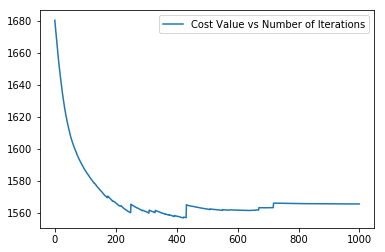

cost function ends at:  1565.363


In [51]:
plt.plot(lfp, '-', label='Cost Value vs Number of Iterations')
# plt.plot(train_X, sess.run(W) * train_X + sess.run(b), label='Fitted line')
plt.legend()
plt.show()
%matplotlib inline

print ("cost function ends at: ", str(lfp[len(lfp)-1]))

# Training Using a NN - Keras
#### We use keras so we can iterate quickly, save our model to be used on the porfolio website

In [32]:
# My Keras model
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import mean_squared_error

In [33]:
# Our data. Keras will automatically take care of the validation data
training_y = submissions['upvotes'].values
training_x = counts.values

In [34]:
# Creating our DNN
model = Sequential([
    Dense(1,input_shape =(counts.shape[1],), activation = 'relu')
    ])

model.summary()

"""
# Compiling
- optimizer (learning rate)
- loss function
- metrics: array of metrics you want to use to judge the model. Look up documentation
"""
model.compile(Adam(lr=0.005), loss = 'mean_squared_error', metrics=['accuracy'])

# The training step which includes the validaton set. validation_split automatically splits up x% of samples
model.fit(training_x,training_y, batch_size = 40,validation_split=0.02, epochs=3, shuffle=True, verbose=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 272       
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________
Train on 2744 samples, validate on 56 samples
Epoch 1/3
 - 0s - loss: 1665.3094 - acc: 0.0259 - val_loss: 1267.0453 - val_acc: 0.0893
Epoch 2/3
 - 0s - loss: 1658.2428 - acc: 0.2828 - val_loss: 1259.4754 - val_acc: 0.5000
Epoch 3/3
 - 0s - loss: 1651.4657 - acc: 0.5022 - val_loss: 1252.4549 - val_acc: 0.4643


In [136]:
# Now we predict!
def predict_upvotes(text):
    counts_p = pd.DataFrame(0, index = np.arange(1), columns = list(counts.columns))
    
    for i, x in enumerate([text]):
        for word in x:            
            if word in counts.columns:
                counts_p.iloc[i][word] += 1
            
    return counts_p.T.values.reshape(271,)
    
predict_upvotes('use big')           
#model.predict(predict_upvotes('use big')   )


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [126]:
preprocess_columns = list(counts.columns)

counts_p = pd.DataFrame(0, index = np.arange(1), columns = preprocess_columns)

for i, x in enumerate(['hello my name name is bob bo bob ']):
    for word in x:            
        if word in preprocess_columns:
            counts_p.iloc[i][word] += 1   

word = counts_p
prediction = model.predict(word)  
print (prediction)

[[1.4445044]]


In [118]:
"""
Next
- save the model
- put that in the website
"""

model.save('C:/Users/Darshil/gitly/Deep-Learning/My Projects/predicting_upvotes.h5')

In [70]:
from keras.models import load_model
new_model = load_model('C:/Users/Darshil/gitly/Deep-Learning/My Projects/Flask_Keras/saved_models/predicting_upvotes.h5')

# now lets look at the model history, weights and which optimizer it used
new_model.summary()
new_model.predict(predict_upvotes('please please God'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1)                 272       
Total params: 272
Trainable params: 272
Non-trainable params: 0
_________________________________________________________________


array([[1.0856596]], dtype=float32)

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
data_corpus = ["John likes to watch movies. Mary likes movies too."]
X = vectorizer.fit_transform(data_corpus) 
Y = vectorizer.fit_transform(['John']) 
print(X.toarray())
print(vectorizer.get_feature_names())

[[1 2 1 2 1 1 1]]
['john']
